In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dc_stat_think.original import *
from scipy import stats

force_a=np.array([1.612, 0.605, 0.327, 0.946, 0.541, 1.539, 0.529, 0.628, 1.453,
       0.297, 0.703, 0.269, 0.751, 0.245, 1.182, 0.515, 0.435, 0.383,
       0.457, 0.73 ]) 


force_b=np.array([0.172, 0.142, 0.037, 0.453, 0.355, 0.022, 0.502, 0.273, 0.72 ,
       0.582, 0.198, 0.198, 0.597, 0.516, 0.815, 0.402, 0.605, 0.711,
       0.614, 0.468])

class PlotsForHypothesis(object):

    def plot_hist(self,values, low=None, high=None):
        plt.figure(figsize=(8,8))
        options = dict(alpha=0.5, color='C0')
        xs, ys, patches = plt.hist(values,
                               density=True,
                               histtype='step', 
                               linewidth=3,
                               **options)
        plt.ylabel('Density')
        plt.tight_layout()
    
        return patches[0]
    def fill_hist(self,low, high, patch):
        options = dict(alpha=0.5, color='red')
        fill = plt.axvspan(low, high, 
                       clip_path=patch,
                       **options)
    def annotate(self,text, x, y, length):
        arrowprops = dict(width=1, headwidth=6, facecolor='black')
        plt.annotate(text,
                     xy=(x, y),
                 xytext=(x, y+length),
                 ha='center',
                 arrowprops=arrowprops)    

In [3]:
class HypothesisTest(PlotsForHypothesis):
    '''
    NULL SIGNIFICANCE HYPOTHESIS TEST 
    
    H0 : means are the same
    
    Ha : they are not 
    
    test_statistic : difference of means under the null hypothesis should be 0 using permutation test
    
    p-value : how many times did i get value that's as extreme as the actual value or more.
    '''
    def __init__(self, data1 , data2):
        self.data1 = data1
        self.data2 = data2
        self.actual_statistic = self.calc_test_statistic(self.data1 , self.data2)
        self.test_stats = self.run_simulation('bootstrap')
        self.size=10000
        self.std_error = np.std(self.test_stats) / self.size
        self.confidence_intervals=np.percentile(self.test_stats , [2.5 , 97.5])
        self.test_statistic_name = 'Different Of Means'
        self.p=self.p_value()
        
    def p_value(self):
        p_value = np.sum(self.test_stats >= self.actual_statistic) / len(self.test_stats)
        return p_value
        
    def calc_test_statistic(self,d1 , d2):
        diff = np.abs(np.mean(d1) - np.mean(d2))
        return diff
    
    def run_simulation(self , kind='perm'):
        if(kind == 'perm'):
            print("NHST using Permutation Test !")
            # Draw 10,000 permutation replicates: perm_replicates
            perm_replicates = draw_perm_reps(self.data1 , self.data2 , self.calc_test_statistic , size=10000)
            return perm_replicates
        elif(kind == 'bootstrap'):
            '''we first shift the arrays to global mean , then do bootstrap on each ALONE'''
            print("NHST using Bootstrap !")
            # Concatenate arrays: bout_lengths_concat
            all_data = np.concatenate((self.data1, self.data2))
            
            # Compute mean of all bout_lengths: mean_bout_length
            global_mean = np.mean(all_data)
            
            # Generate shifted arrays
            shifted_data1 = self.data1 - np.mean(self.data1) + global_mean
            shifted_data2 = self.data2 - np.mean(self.data2) + global_mean

            # Compute 10,000 bootstrap replicates from shifted arrays
            bs_reps_data1 = draw_bs_reps(shifted_data1 , np.mean, size=10000)
            bs_reps_data2 = draw_bs_reps(shifted_data2 , np.mean, size=10000)
            
            # return the absolute difference 
            return np.abs(bs_reps_data1 - bs_reps_data2)

    def evaluate(self):
        patch = self.plot_hist(self.test_stats)
        low = self.actual_statistic
        high = np.max(self.test_stats)
        self.fill_hist(low, high, patch)
        plt.title('Distribution of test stat under null')
        plt.axvline(x=self.actual_statistic,color='red', label='Actual Statsitc value')
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
        print("The Actual Value for "+self.test_statistic_name + " = " + str(self.actual_statistic))
        print("95% confidence Interval : " , self.get_confidence_intervals())
        print("P-Value = " , self.p)
        if(self.p <= 0.05):
            print("The Null Hypothesis Is rejected!")
        else :
            print("We failed to Reject the Null Hypothesis")
        print("Sampling size =" , self.size)
        print("Standard Error =" ,self.std_error)
        self.annotate('P-Value' , 1.1*self.actual_statistic , 0.3 , 1)

    def get_confidence_intervals(self):
        '''the analytic way'''
        diff_of_meanss=np.mean(self.data1) - np.mean(self.data2)
        df=len(self.data1) + len(self.data2) -2
        t_value=stats.t.ppf(0.95, df)
        var1_squared=np.var(self.data1) **2
        var2_squared=np.var(self.data2) ** 2
        Sp=np.sqrt((len(self.data1)* var1_squared + len(self.data2) *var2_squared) / (len(self.data1) + len(self.data2) -2))
        factor=np.sqrt(1/len(self.data1) + 1/len(self.data2))
        ci=t_value * Sp * factor
        return (diff_of_meanss - ci ,  diff_of_meanss+ci)

NHST using Bootstrap !
The Actual Value for Different Of Means = 0.28825000000000006
95% confidence Interval :  (0.21898163325595815, 0.35751836674404197)
P-Value =  0.0067
The Null Hypothesis Is rejected!
Sampling size = 10000
Standard Error = 6.268735398303532e-06


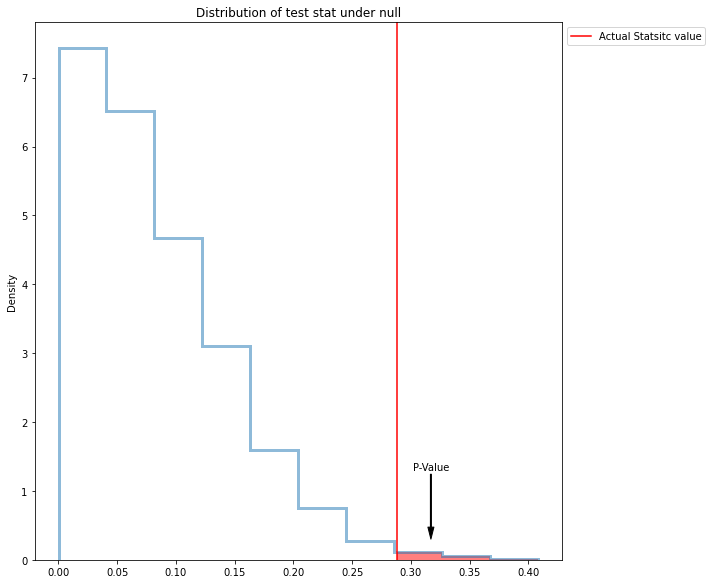

In [4]:
tester=HypothesisTest(force_a , force_b)
tester.evaluate()